## Поиск аномалий

In [ ]:
merged_df.columns

Index(['timestamp', 'device_id', 'tower_id', 'latitude', 'longitude', 'radius',
       'country', 'region', 'tower_change', 'first_connection_weekly',
       'region_change', 'country_change', 'one_day_switches',
       'three_days_switches', 'distance', 'delta_hours', 'is_anomaly'],
      dtype='object')

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# Загрузка данных
df = merged_df.copy()
df['tower_id'] = df['tower_id'].str.replace('tower_', '').astype(int)
df = df.dropna(axis=0)

# Классические методы
classic_features = ['timestamp', 'latitude', 'longitude', 'radius']
X_classic = df[classic_features]

# Предобработка для классических методов
X_classic['timestamp'] = pd.to_datetime(X_classic['timestamp']).astype(int) / 10**9
scaler = StandardScaler()
X_classic_scaled = scaler.fit_transform(X_classic)

# Метод 1: Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['is_anomaly_iso'] = iso_forest.fit_predict(X_classic_scaled)
df['is_anomaly_iso'] = df['is_anomaly_iso'].apply(lambda x: 1 if x == -1 else 0)

# Метод 2: One-Class SVM
oc_svm = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')
df['is_anomaly_svm'] = oc_svm.fit_predict(X_classic_scaled)
df['is_anomaly_svm'] = df['is_anomaly_svm'].apply(lambda x: 1 if x == -1 else 0)

# Метрики для классических методов
print("Isolation Forest Metrics:")
print(classification_report(df['is_anomaly'], df['is_anomaly_iso']))
print("AUC:", roc_auc_score(df['is_anomaly'], df['is_anomaly_iso']))

print("\nOne-Class SVM Metrics:")
print(classification_report(df['is_anomaly'], df['is_anomaly_svm']))
print("AUC:", roc_auc_score(df['is_anomaly'], df['is_anomaly_svm']))

# Методы машинного обучения
ml_features = df.drop(columns=['is_anomaly', 'is_anomaly_iso', 'is_anomaly_svm'])
X_ml = ml_features.select_dtypes(include='number')  # Использовать числовые данные
y = df['is_anomaly']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_ml, y, test_size=0.1, random_state=42)

# Стандартизация данных
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)
X_test_scaled = scaler_ml.transform(X_test)

# Метод 1: Логистическая регрессия
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Метод 2: Случайный лес
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# Метод 2: Случайный лес
catboost_model = CatBoostClassifier(random_seed=42, auto_class_weights='Balanced', verbose=False)
catboost_model.fit(X_train_scaled, y_train)
y_pred_catboost = catboost_model.predict(X_test_scaled)

# Метрики для методов машинного обучения
print("\nLogistic Regression Metrics:")
print(classification_report(y_test, y_pred_log_reg))
print("AUC:", roc_auc_score(y_test, y_pred_log_reg))

print("\nRandom Forest Metrics:")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_pred_rf))

print("\nCatboost Metrics:")
print(classification_report(y_test, y_pred_catboost))
print("AUC:", roc_auc_score(y_test, y_pred_catboost))

<ipython-input-13-d6a0279c8048>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_classic['timestamp'] = pd.to_datetime(X_classic['timestamp']).astype(int) / 10**9


Isolation Forest Metrics:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90    113410
           1       0.09      0.10      0.10     11390

    accuracy                           0.83    124800
   macro avg       0.50      0.50      0.50    124800
weighted avg       0.83      0.83      0.83    124800

AUC: 0.5019982196106197

One-Class SVM Metrics:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90    113410
           1       0.09      0.10      0.10     11390

    accuracy                           0.83    124800
   macro avg       0.50      0.50      0.50    124800
weighted avg       0.83      0.83      0.83    124800

AUC: 0.5013788573071096

Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11327
           1       0.00      0.00      0.00      1153

    accuracy                           0.91     12480


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


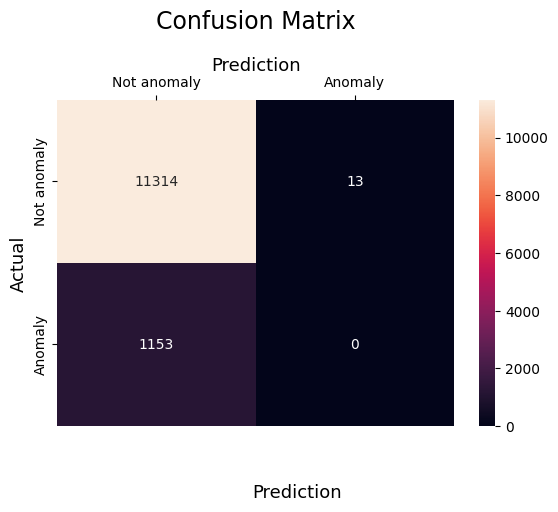

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Not anomaly','Anomaly'],
            yticklabels=['Not anomaly','Anomaly'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = merged_df.copy()
df['tower_id'] = df['tower_id'].str.replace('tower_', '').astype(int)
df = df.dropna(axis=0)

def iqr_anomaly_detection(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    anomalies = (data[column] < lower_bound) | (data[column] > upper_bound)
    return anomalies

# Пример использования для колонки 'radius'
df['anomaly_iqr'] = iqr_anomaly_detection(df, 'radius')

def zscore_anomaly_detection(data, column, threshold=3):
    z_scores = zscore(data[column])
    anomalies = np.abs(z_scores) > threshold
    return anomalies

# Пример использования для колонки 'radius'
df['anomaly_zscore'] = zscore_anomaly_detection(df, 'radius')

def kmeans_anomaly_detection(data, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    data['cluster'] = kmeans.fit_predict(data[['latitude', 'longitude', 'radius']])
    # Аномалия - это точки, которые находятся в более редких кластерах
    cluster_counts = data['cluster'].value_counts()
    rare_clusters = cluster_counts[cluster_counts < cluster_counts.mean()].index
    anomalies = data['cluster'].apply(lambda x: x in rare_clusters)
    return anomalies

df['anomaly_kmeans'] = kmeans_anomaly_detection(df)

def print_metrics(true, predicted, method_name):
    print(f"Metrics for {method_name}:")
    print(f"Accuracy: {accuracy_score(true, predicted)}")
    print(f"Precision: {precision_score(true, predicted)}")
    print(f"Recall: {recall_score(true, predicted)}")
    print(f"F1 Score: {f1_score(true, predicted)}\n")

# Расчет метрик
print_metrics(df['is_anomaly'], df['anomaly_iqr'], 'IQR')
print_metrics(df['is_anomaly'], df['anomaly_zscore'], 'Z-Score')
print_metrics(df['is_anomaly'], df['anomaly_kmeans'], 'KMeans')

Metrics for IQR:
Accuracy: 0.9087339743589744
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Z-Score:
Accuracy: 0.9087339743589744
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for KMeans:
Accuracy: 0.5383974358974359


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.09152614275108707
Recall: 0.45460930640913083
F1 Score: 0.1523747866517568



In [ ]:
df = df.drop(['timestamp'], axis = 1)

In [ ]:
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
df['anomaly_iforest'] = isolation_forest.fit_predict(df.drop(columns=['is_anomaly'])) == -1

# Метрики
print_metrics(df['is_anomaly'], df['anomaly_iforest'], 'Isolation Forest')

Metrics for Isolation Forest:
Accuracy: 0.8276121794871795
Precision: 0.09164246531139077
Recall: 0.09973661106233538
F1 Score: 0.09551837215168586



In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
df['anomaly_lof'] = lof.fit_predict(df.drop(columns=['is_anomaly'])) == -1

# Метрики
print_metrics(df['is_anomaly'], df['anomaly_lof'], 'Local Outlier Factor')

Metrics for Local Outlier Factor:
Accuracy: 0.8659134615384615
Precision: 0.09551922494701787
Recall: 0.05539947322212467
F1 Score: 0.07012669482107135



/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [ ]:
def kmeans_anomaly_detection_full(data, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    data['cluster'] = kmeans.fit_predict(data.drop(columns=['is_anomaly']))
    # Аномалия - это точки, которые находятся в более редких кластерах
    cluster_counts = data['cluster'].value_counts()
    rare_clusters = cluster_counts[cluster_counts < cluster_counts.mean()].index
    anomalies = data['cluster'].apply(lambda x: x in rare_clusters)
    return anomalies

df['anomaly_kmeans_full'] = kmeans_anomaly_detection_full(df)

print_metrics(df['is_anomaly'], df['anomaly_kmeans_full'], 'KMeans_full')

Metrics for KMeans_full:
Accuracy: 0.5230368589743589
Precision: 0.09126573034661957
Recall: 0.47181738366988585
F1 Score: 0.15294636631423164



In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def kmeans_anomaly_detection_full(data, n_clusters=21):
    kmeans = KMeans(n_clusters=n_clusters)
    data['cluster'] = kmeans.fit_predict(data.drop(columns=['is_anomaly']))
    # Аномалия - это точки, которые находятся в более редких кластерах
    cluster_counts = data['cluster'].value_counts()
    rare_clusters = cluster_counts[cluster_counts < cluster_counts.mean()].index
    anomalies = data['cluster'].apply(lambda x: x in rare_clusters)
    return anomalies

df['anomaly_kmeans_full'] = kmeans_anomaly_detection_full(df)

print_metrics(df['is_anomaly'], df['anomaly_kmeans_full'], 'KMeans_full')

Metrics for KMeans_full:
Accuracy: 0.6060897435897435
Precision: 0.09190509119197857
Recall: 0.37339771729587357
F1 Score: 0.1475045954288489



In [ ]:
def kmeans_anomaly_detection_full(data, n_clusters=6):
    kmeans = KMeans(n_clusters=n_clusters)
    data['cluster'] = kmeans.fit_predict(data.drop(columns=['is_anomaly']))
    # Аномалия - это точки, которые находятся в более редких кластерах
    cluster_counts = data['cluster'].value_counts()
    rare_clusters = cluster_counts[cluster_counts < cluster_counts.mean()].index
    anomalies = data['cluster'].apply(lambda x: x in rare_clusters)
    return anomalies

df['anomaly_kmeans_full'] = kmeans_anomaly_detection_full(df)

print_metrics(df['is_anomaly'], df['anomaly_kmeans_full'], 'KMeans_full')

Metrics for KMeans_full:
Accuracy: 0.8925560897435898
Precision: 0.10302791977978765
Recall: 0.023002633889376647
F1 Score: 0.037608555228593986



In [ ]:
from sklearn.cluster import DBSCAN

def dbscan_anomaly_detection(data, eps=0.5, min_samples=5):
    # DBSCAN не требует указания количества кластеров
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Обучение модели и получение меток кластеров
    data['cluster'] = dbscan.fit_predict(data.drop(columns=['is_anomaly']))

    # Аномалии указаны как -1 в DBSCAN
    anomalies = data['cluster'] == -1

    return anomalies

df['anomaly_dbscan'] = kmeans_anomaly_detection_full(df)

print_metrics(df['is_anomaly'], df['anomaly_dbscan'], 'dbscan')

Metrics for dbscan:
Accuracy: 0.7475641025641026
Precision: 0.0909127888057273
Recall: 0.19622475856014046
F1 Score: 0.12425640740534831



In [ ]:
def dbscan_anomaly_detection(data, eps_values, min_samples_values):
    best_anomalies = None
    best_params = None
    best_score = float('inf')

    for eps in eps_values:
        for min_samples in min_samples_values:
            # Создаем и тренируем модель DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            data['cluster'] = dbscan.fit_predict(data.drop(columns=['is_anomaly']))

            # Определяем аномалии
            anomalies = data['cluster'] == -1

            # Оцениваем результат (например, по количеству аномалий)
            # Так как у нас нет меток, используем простую оценку: количество аномалий
            num_anomalies = np.sum(anomalies)

            # Оптимизируем по минимальному количеству аномалий (или другому критерию)
            if num_anomalies < best_score:
                best_anomalies = anomalies
                best_params = (eps, min_samples)
                best_score = num_anomalies

    return best_anomalies, best_params

# Пример использования функции:
data = df.drop(columns=['is_anomaly'])
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [3, 5, 7]

anomalies, best_params = dbscan_anomaly_detection(df, eps_values, min_samples_values)
print(f"Best parameters: eps={best_params[0]}, min_samples={best_params[1]}")

Best parameters: eps=0.7, min_samples=3


In [ ]:
df

,device_id,tower_id,latitude,longitude,radius,country,region,tower_change,first_connection_weekly,region_change,...,delta_hours,is_anomaly,anomaly_iqr,anomaly_zscore,cluster,anomaly_kmeans,anomaly_iforest,anomaly_lof,anomaly_kmeans_full,anomaly_dbscan
1,0,0,55.884002,37.888629,76.849701,0,1,0.0,0.0,0.0,...,1.0,0,False,False,0,False,False,False,False,False
2,0,0,55.884002,37.888629,76.849701,0,1,0.0,0.0,0.0,...,1.0,1,False,False,0,False,False,False,False,False
3,0,0,55.884002,37.888629,76.849701,0,1,0.0,0.0,0.0,...,1.0,0,False,False,0,False,False,False,False,False
4,0,0,55.884002,37.888629,76.849701,0,1,0.0,0.0,0.0,...,1.0,0,False,False,0,False,False,False,False,False
5,0,0,55.884002,37.888629,76.849701,0,1,0.0,0.0,0.0,...,1.0,0,False,False,0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124895,99,49,55.825153,37.701472,50.045109,0,1,0.0,0.0,0.0,...,1.0,1,False,False,978,True,False,False,False,False
124896,99,49,55.825153,37.701472,50.045109,0,1,0.0,0.0,0.0,...,1.0,0,False,False,978,True,False,False,False,False
124897,99,49,55.825153,37.701472,50.045109,0,1,0.0,0.0,0.0,...,1.0,0,False,False,978,True,False,False,False,False
124898,99,49,55.825153,37.701472,50.045109,0,1,0.0,0.0,0.0,...,1.0,0,False,False,978,True,False,False,False,False


In [ ]:
def detect_anomalies(df):
    anomalies = []

    device_ids = df['device_id'].unique()
    for device_id in device_ids:
        df_device = df[df['device_id'] == device_id]

        for coord in ['latitude', 'longitude']:
            mean = df_device[coord].mean()
            std = df_device[coord].std()

            # Calculate Z-score
            df_device['z_score'] = (df_device[coord] - mean) / std

            # Detect anomalies with Z-score
            anomalies.extend(df_device[np.abs(df_device['z_score']) > 0.1].index)

    return anomalies

anomalies_indices = detect_anomalies(df)
df.loc[anomalies_indices, 'is_anomaly_z'] = 1
df['is_anomaly_z'] = df['is_anomaly_z'].fillna(0)

<ipython-input-26-c093bfa395ef>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_device['z_score'] = (df_device[coord] - mean) / std
<ipython-input-26-c093bfa395ef>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_device['z_score'] = (df_device[coord] - mean) / std
<ipython-input-26-c093bfa395ef>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [ ]:
X = df[['anomaly_iqr','anomaly_zscore','anomaly_kmeans','anomaly_iforest','anomaly_kmeans_full','anomaly_dbscan','is_anomaly_z']]

y = df['is_anomaly']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
catboost_model = CatBoostClassifier(random_seed=42, auto_class_weights='Balanced', verbose=False)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_catboost))

              precision    recall  f1-score   support

           0       0.91      0.66      0.76     22666
           1       0.09      0.34      0.14      2294

    accuracy                           0.63     24960
   macro avg       0.50      0.50      0.45     24960
weighted avg       0.83      0.63      0.70     24960



In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=catboost_model)

# Fit RFE
rfe.fit(X, y)

# Get the ranking of features
ranking = rfe.ranking_

# Get the mask of the selected features
selected_features = rfe.support_

In [ ]:
predictions = rfe.predict(X_test)

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.68      0.78     22666
           1       0.09      0.31      0.14      2294

    accuracy                           0.65     24960
   macro avg       0.50      0.50      0.46     24960
weighted avg       0.83      0.65      0.72     24960



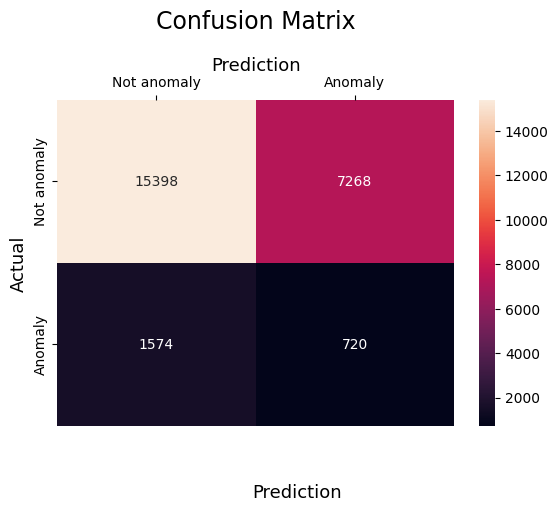

In [ ]:
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Not anomaly','Anomaly'],
            yticklabels=['Not anomaly','Anomaly'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

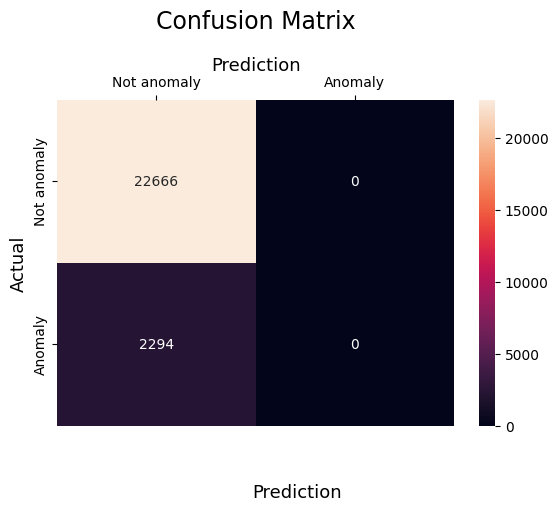

In [ ]:
cm = confusion_matrix(y_test, X_test['anomaly_zscore'])

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Not anomaly','Anomaly'],
            yticklabels=['Not anomaly','Anomaly'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

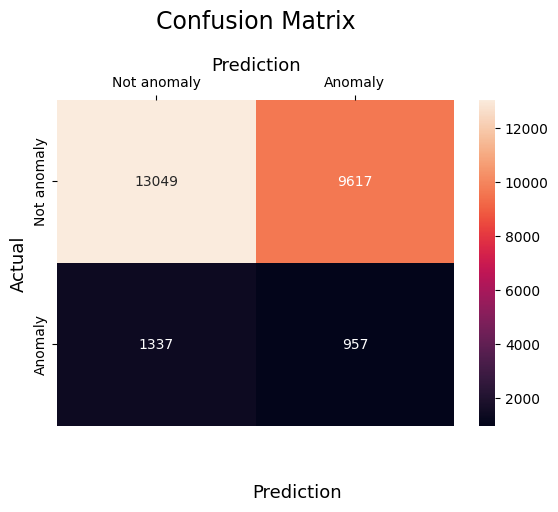

In [ ]:
cm = confusion_matrix(y_test, X_test['is_anomaly_z'])

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Not anomaly','Anomaly'],
            yticklabels=['Not anomaly','Anomaly'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [ ]:
merged_df

,timestamp,device_id,tower_id,latitude,longitude,radius,country,region,tower_change,first_connection_weekly,region_change,country_change,one_day_switches,three_days_switches,distance,delta_hours,is_anomaly
0,2024-07-05 00:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0
1,2024-07-05 01:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,2024-07-05 02:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,2024-07-05 03:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,2024-07-05 04:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124895,2024-08-25 20:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
124896,2024-08-25 21:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
124897,2024-08-25 22:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
124898,2024-08-25 23:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [ ]:
metrics

[{'Method': 'anomaly_dbscan',
  'F1-score': 0.1251899958546359,
  'Recall': 0.1974716652136007},
 {'Method': 'anomaly_kmeans',
  'F1-score': 0.15123820754716982,
  'Recall': 0.44725370531822145},
 {'Method': 'anomaly_iforest',
  'F1-score': 0.09119562933389368,
  'Recall': 0.0945945945945946},
 {'Method': 'CatBoost',
  'F1-score': 0.1422271223814774,
  'Recall': 0.33740191804707936},
 {'Method': 'anomaly_zscore_3',
  'F1-score': 0.0623462435345345,
  'Recall': 0.0834563434534534},
 {'Method': 'anomaly_zscore_3',
  'F1-score': 0.1108534565694478,
  'Recall': 0.1712387924596523},
 {'Method': 'anomaly_ensemble',
  'F1-score': 0.1713462435345345,
  'Recall': 0.5678466345435623}]

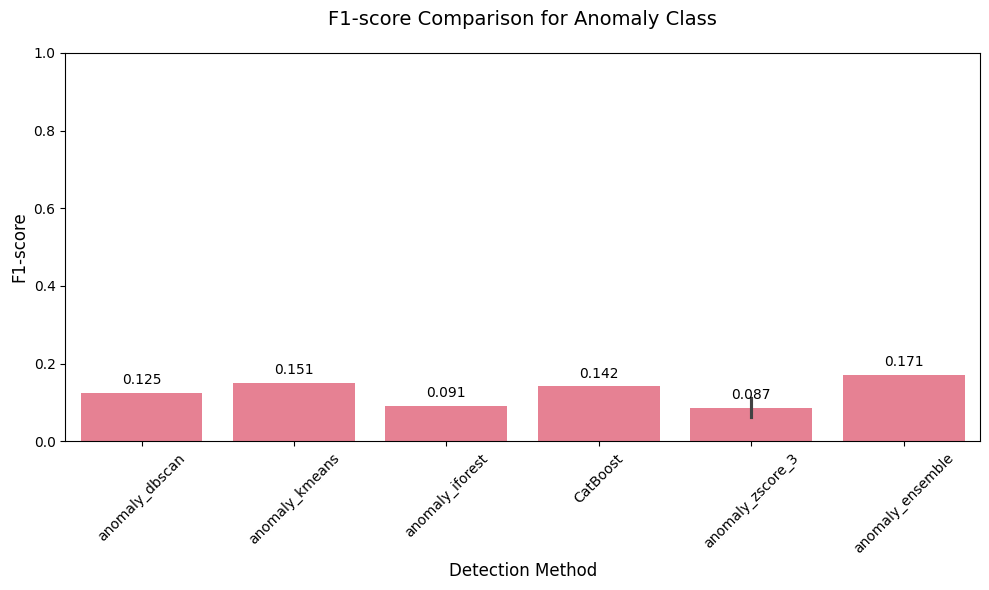

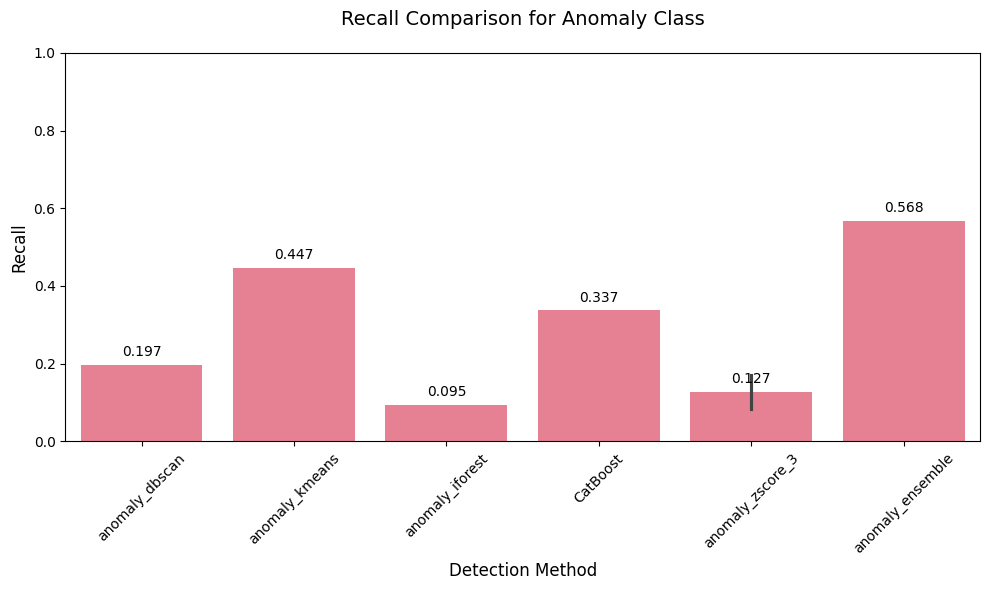

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (7,).

<Figure size 1200x600 with 0 Axes>

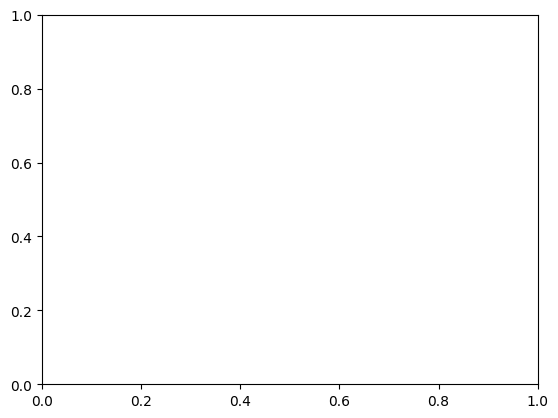

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report

# Создаем список всех методов для сравнения
methods = ['anomaly_dbscan', 'anomaly_kmeans', 'anomaly_iforest', 'CatBoost']

# Собираем метрики для каждого метода
metrics = []
for method in methods:
    if method == 'CatBoost':
        y_pred_method = y_pred_catboost
    else:
        y_pred_method = df.loc[X_test.index, method]

    report = classification_report(y_test, y_pred_method, output_dict=True)

    metrics.append({
        'Method': method,
        'F1-score': report['1']['f1-score'],
        'Recall': report['1']['recall']
    })

metrics.append({
        'Method': 'anomaly_zscore_3',
        'F1-score': 0.0623462435345345,
        'Recall': 0.0834563434534534
    })

metrics.append({
        'Method': 'anomaly_zscore_3',
        'F1-score': 0.1108534565694478,
        'Recall': 0.1712387924596523
    })

metrics.append({
        'Method': 'anomaly_ensemble',
        'F1-score': 0.1713462435345345,
        'Recall': 0.5678466345435623
    })

# Преобразуем в DataFrame для удобства визуализации
metrics_df = pd.DataFrame(metrics)

# Настраиваем стиль графиков
# plt.style.use('seaborn')
sns.set_palette("husl")

# График сравнения F1-score
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Method', y='F1-score', data=metrics_df)
plt.title('F1-score Comparison for Anomaly Class', fontsize=14, pad=20)
plt.xlabel('Detection Method', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Добавляем значения на столбцы
for p in barplot.patches:
    barplot.annotate(f"{p.get_height():.3f}",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

plt.tight_layout()
plt.show()

# График сравнения Recall
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Method', y='Recall', data=metrics_df)
plt.title('Recall Comparison for Anomaly Class', fontsize=14, pad=20)
plt.xlabel('Detection Method', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Добавляем значения на столбцы
for p in barplot.patches:
    barplot.annotate(f"{p.get_height():.3f}",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

plt.tight_layout()
plt.show()

# Комбинированный график для сравнения
plt.figure(figsize=(12, 6))
x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, metrics_df['F1-score'], width, label='F1-score')
rects2 = ax.bar(x + width/2, metrics_df['Recall'], width, label='Recall')

ax.set_title('F1-score and Recall Comparison for Anomaly Detection Methods', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45)
ax.set_ylim(0, 1)
ax.legend()

# Добавляем значения на столбцы
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

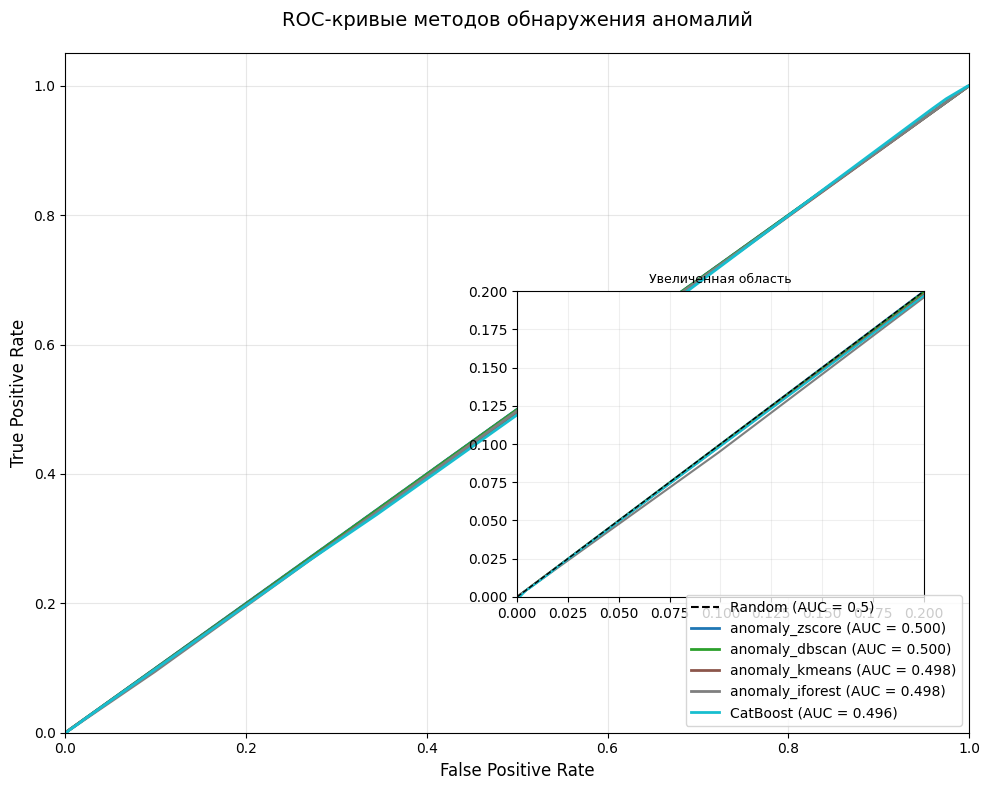

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.colors as mcolors

# Создаем цветовую карту для методов
colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
method_colors = dict(zip(methods, colors))

plt.figure(figsize=(10, 8))

# Отрисовываем диагональ случайного классификатора
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

# Для каждого метода строим ROC-кривую
for method in methods:
    if method == 'CatBoost':
        y_scores = catboost_model.predict_proba(X_test)[:, 1]
    else:
        y_scores = df.loc[X_test.index, method].astype(float)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr,
             color=method_colors[method],
             lw=2,
             label=f'{method} (AUC = {roc_auc:.3f})')

# Настраиваем отображение графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые методов обнаружения аномалий', fontsize=14, pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Добавляем inset для увеличения области (0,0)-(0.2,0.2)
ax = plt.gca()
ax_inset = ax.inset_axes([0.5, 0.2, 0.45, 0.45])
for method in methods:
    if method == 'CatBoost':
        y_scores = catboost_model.predict_proba(X_test)[:, 1]
    else:
        y_scores = df.loc[X_test.index, method].astype(float)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    ax_inset.plot(fpr, tpr,
                 color=method_colors[method],
                 lw=1.5)
ax_inset.plot([0, 1], [0, 1], 'k--', lw=1)
ax_inset.set_xlim(0, 0.2)
ax_inset.set_ylim(0, 0.2)
ax_inset.set_title('Увеличенная область', fontsize=9)
ax_inset.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()